# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 17
### <center> Yoshihiro Shirai

# Recurrent Neural Networks

- These lecture notes are partially based on "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition, by Aurelien Geron (O'Reilly), 2022."

- Chapter 15: recurrent neural networks, time series data, LSTM.

# 0. Overview of the lecture

- We discuss recurrent neural networks (RNNs) that can be used for predicting future values of a sequence, such as time series.

- Then we discuss how to work with time series data in supervised learning.

- We provide an example from time series to show how simple RNNs and later long short term memory (LSTM) cells can be used for time series prediction.

# 1. Recurrent neurons

- So far, we have only considered feedforward networks where information flows only in one direction, namely, from the input layer to the output layer.

- A recurrent neural network (RNN) architecture differs from a feedforward network in that some of the output of neurons are fed back into the network. This models the flow of a information or memory over time by using a hidden state.

- The main application of RNNs that we are concerned with is time series prediction. Other applications include natural language processing, such as automatic translation or speech-to-text.

- Consider the following simple recurrent neuron.

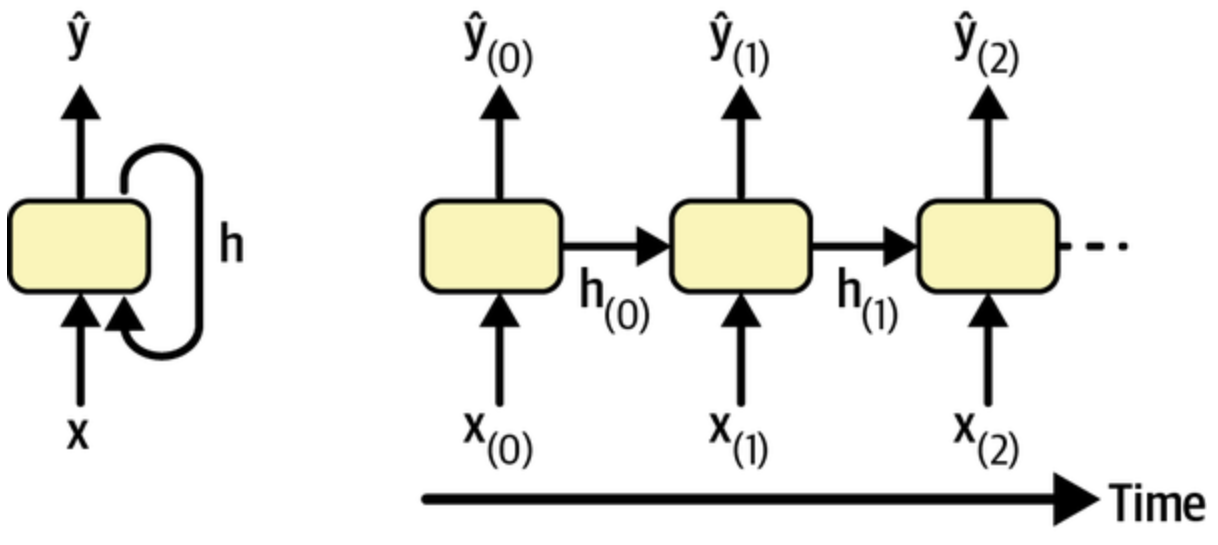

In [1]:
from IPython.display import Image
Image("Figs/RN-Cell.png",width=600)

- At each time step (or frame) t, the neuron is fed two inputs:
    - $\mathbf{x}_t$: the inputs at time t
    - $\mathbf{h}_{t-1}$: the hidden state from previous time $t-1$

- At each time step, the neuron has two outputs:
    - $\mathbf{y}_t$: its output, which is fed to the next layer or a loss function (if the neuron is in the top layer).
    - $\mathbf{h}_{t}$: the hidden state which will be fed to the neuron in the next time step.

- The hidden state is a function of $\mathbf{x}_t$ and $\mathbf{h}_{t-1}$, say, $\mathbf{h}_t=\mathbf{f}(\mathbf{x}_t,\mathbf{h}_{t-1})$ for some function $\mathbf{f}$. The output is also a function of these two quantities, say, $\mathbf{y}_t=\mathbf{g}(\mathbf{x},\mathbf{h}_{t-1})$ for some function $\mathbf{g}$.

- The exact relationship varies between different types of recurrent neurons.

- We can see the evolution of the recurrent neuron through time steps. This is called unrolling (or unfolding) the network through time.

- In the previous example, we assumed that the hidden states and output are different. This is the general case. The hidden state and output can be the same, as shown below.

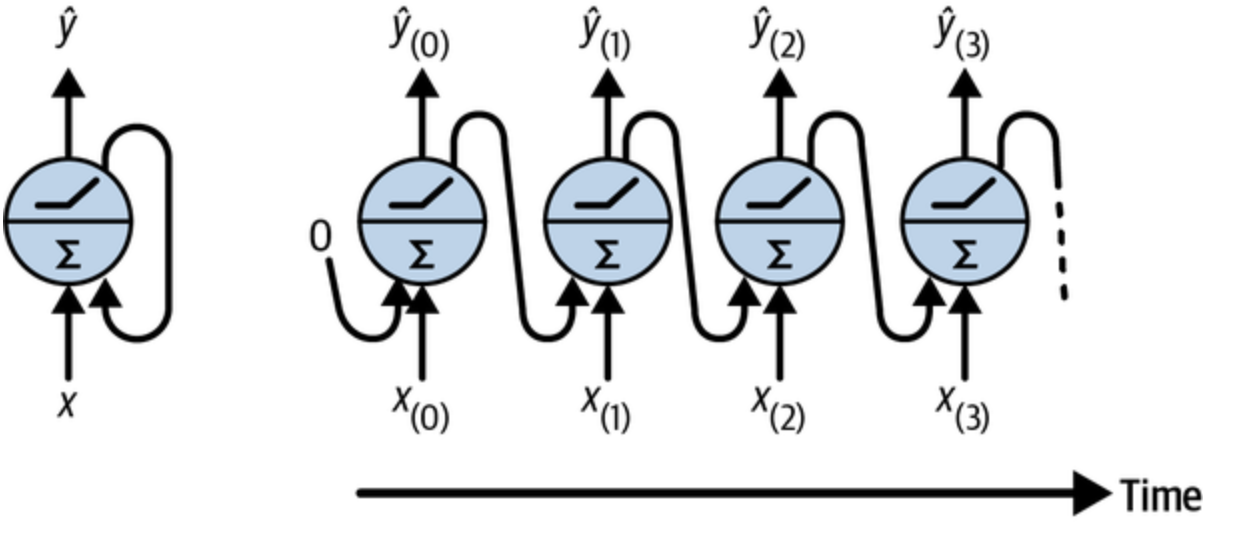

In [2]:
Image("Figs/RN-Cell-2.png",width=600)

- We can consider a layer of recurrent neurons. Note that at each time, neurons are fed the input $\mathbf{x}_t$ as well as the hidden states of all the neurons from the previous state, which is $\mathbf{h}_{t-1} = \mathbf{y}_{t-1}$ here.

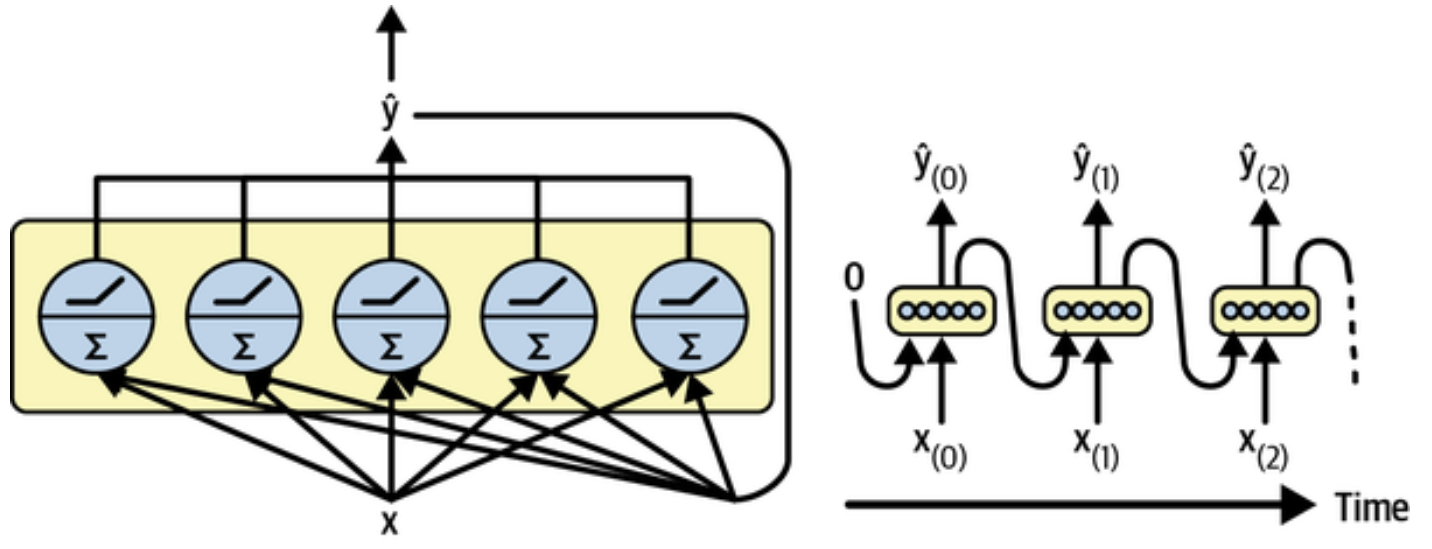

In [3]:
Image("Figs/RN-Layer.png",width=700)

- These are known as Simple RNNs in Keras. The output of neuron $i$ at time $t$ is then
$$\begin{align*}
    \mathbf{y}_t = \phi\left(\mathbf{W}^T_x\mathbf{X}_t+\mathbf{W}^T_y\mathbf{y}_{t-1}+\mathbf{b}\right)
\end{align*}$$

- Here:
    - $\mathbf{W}_x$ is the $n_{inputs}\times n_{neurons}$ weight matrix of inputs
    - $\mathbf{W}_y$ is the $n_{neurons}\times n_{neurons}$ weight matrix of the hidden states
    - $\mathbf{b}$ is the bias
    - $\phi(\cdot)$ is the activation function (applied componentwise)

- Note that the weights are **not** a function of the time step. This is very important. We are unrolling the **same network** through time.

- By using an unrolled RNN, we can create a network that inputs a time series and outputs another times series, **respecting the availability of information through time by not looking into future**.

- By ignoring some outputs or inputs, we can create networks that create a single output from an inputed time series (a **sequence-to-vector** network), or a time series from a single input (a **vector-to-sequence** network).

- Another possibility is to sequentially attach a sequence-to-vector network to a vector-to-sequence network. The resulting architecture is called an **encoder-decoder**.

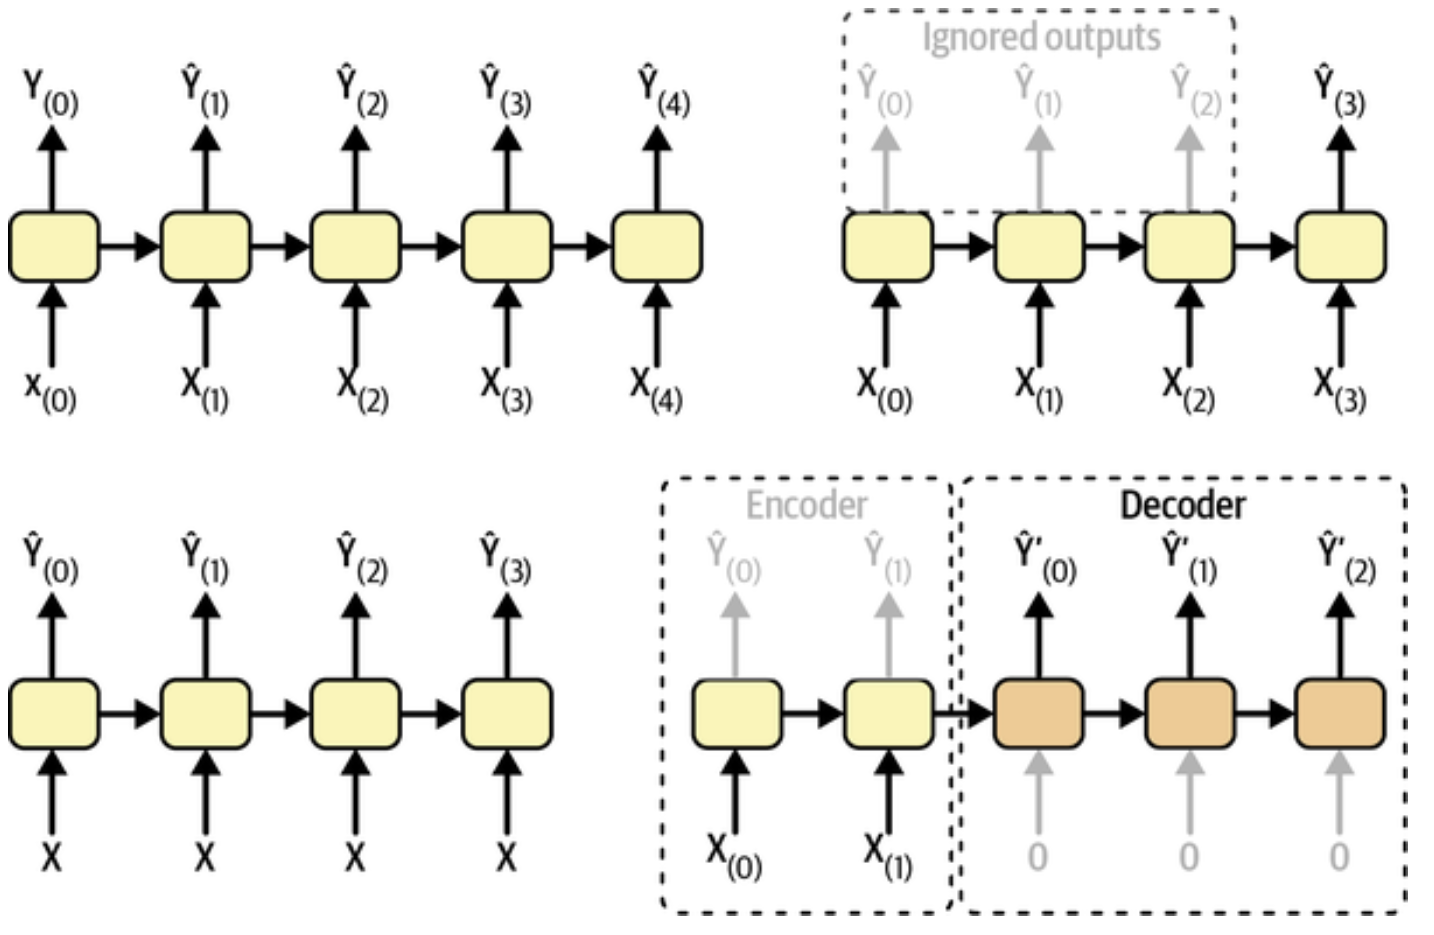

In [4]:
Image("Figs/IO-Sequences.png",width=700)

- To train a RNN, the trick is to unroll it through time to get a feedforward representation of the network. Then, feed sequences (time series) to it and apply backpropagation.

- Note that the weights and biases are shared between different time steps. But ultimately, the network is still a series of function compositions, so the gradient of the cost function can be found by using the chain rule.

- The cost function $J(\mathbf{y}_0,\mathbf{y}_1,...\mathbf{y}_T)$ depends on all the outputs, though some outputs may be ignored depending on the network structure such as the sequence-to-vector network.

- To create a layer of fully connected Simple RNN, you can use `keras.layers.SimpleRNN`.

In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # remove warnings
import tensorflow as tf

In [6]:
tf.keras.layers.SimpleRNN(20, return_sequences=True) 

- It has all the usual arguments such as `units` (the number of neurons), `activation` (the activation function), `kernel_initializer` (initializer of input weights), `kernel_regularizer` (applying $\ell_p$ penalty or input weighs), etc.

- You also have the "recurrent" version of most of the hyperparameters as well. For example, `recurrent_initializer` is the initializer for hidden state weights and `recurrent_regularizer` is the regularizer for hidden state weights.

- There are also special hyperparameters to determine the behavior of the recurrent layer during training and predicting.
    - `return_sequences=True` determines that the layer must output the whole sequence. `return_sequences=False` makes the network output only the output of the last time step.
    - `unroll=True` uses the "unrolled" version of the network. This can considerably speed up the calculations at the cost of using (considerably) more memory.

- Stacking multiple layers of a simple RNN leads to a deep RNN.

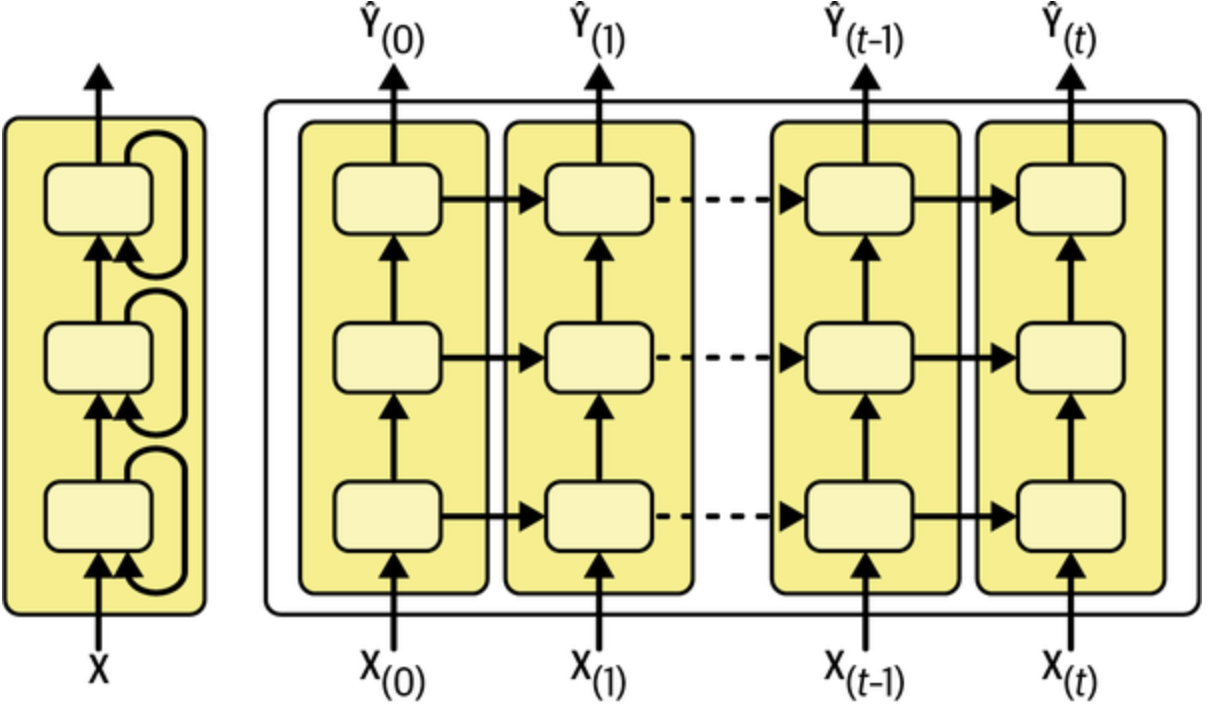

In [7]:
Image("Figs/deep_rnn.png",width=600)

# 2. A time series example

- To illustrate RNNs, let us consider a univariate time series example.

- Let us obtain historical values of the new one family houses sold in the US from January 1963 to Janurary 2022. The frequency is monthly.

In [8]:
import pandas as pd
import pandas_datareader as pdr #make sure pandas_datareader is installed (otherwise run 'pip install pandas_datareader')
from datetime import datetime
HS = pdr.get_data_fred('HSN1FNSA', datetime(1963,1,1),datetime(2023,1,1))

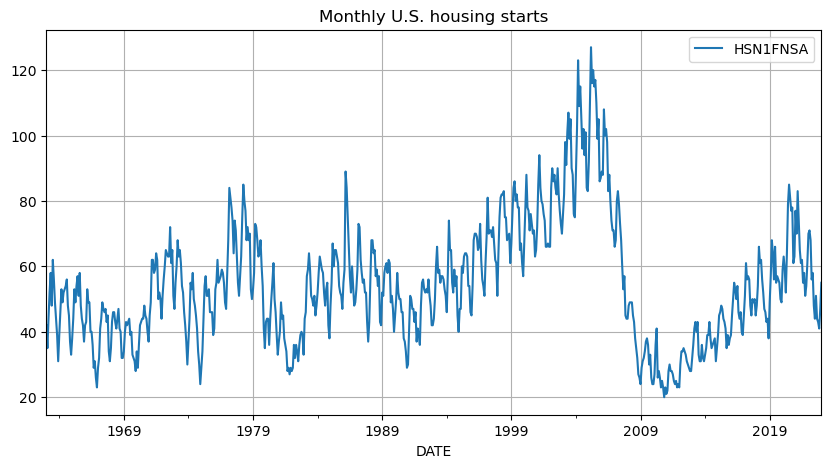

In [9]:
HS.plot(figsize=(10,5))
plt.title("Monthly U.S. housing starts")
plt.grid(True)
plt.show()

- As you can see, there is a strong seasonality in the time series.

## 2.1. Fitting some benchmarks: ARIMA

- Our goal is to use RNNs to forecast future values of this time series.

- It is helpful, however, to have a benchmark model.

- Since the data is seasonal, let us fit an airline model (a special case of seasonal ARIMA) to the time series.

- To fit ARIMA models in Python, we use the package `statsmodels` and the function `ARIMA`.

- "MS" means the freqency is monthly (`M`) and the date of the month is the first day (`S`).

In [10]:
from statsmodels.tsa.arima.model import ARIMA

HS = HS.asfreq("MS")
HS_airline = ARIMA(HS, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
HS_airline = HS_airline.fit()
HS_airline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                         HSN1FNSA   No. Observations:                  721
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2120.205
Date:                          Thu, 25 Jan 2024   AIC                           4246.410
Time:                                  18:38:40   BIC                           4260.098
Sample:                              01-01-1963   HQIC                          4251.699
                                   - 01-01-2023                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1841      0.032     -5.809      0.000      -0.246      -0.122
ma.S.L12      -0.8727      0.021    -41.937      0.000      -0.914      -0.832
sigma2        22.8066      1.080     21.121      0.000      20.690      24.923
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                10.74
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We get the following model:
$$\begin{align*}
\begin{cases}
\Delta\Delta_{12}HS_t = (1-0.1841B)(1-0.8727 B^{12})\varepsilon_t,\\
\varepsilon_t\sim \text{WN}(0,22.8066)
\end{cases}
\end{align*}$$

- Recall that $\Delta=1-B$ is the difference operator and $\Delta_{12}=1-B^{12}$$ is the seasonal difference operator.

- The following code trains the model on data before the year 2000, and predicts 12 steps ahead.

In [11]:
model = ARIMA(HS["1963-01-01":"1999-12-01"],  # train on data up to "today"
                  order=(0, 1, 1),
                  seasonal_order=(0, 1, 1, 12))
model = model.fit()
model.forecast(12)

2000-01-01    63.374996
2000-02-01    70.134125
2000-03-01    79.586317
2000-04-01    78.124038
2000-05-01    77.052749
2000-06-01    75.473347
2000-07-01    72.708630
2000-08-01    74.381803
2000-09-01    68.222909
2000-10-01    67.498026
2000-11-01    62.196600
2000-12-01    58.089669
Freq: MS, Name: predicted_mean, dtype: float64

- Next we create the difference of housing starts and use the previous ARIMA model on the difference (so the order changes to `order=(0, 0, 1)` since the difference is created outside of the model).

- This is done to ensure the ARIMA model is comparable to the RNN models later which will be fit and evaluated on the differenced series.

- Next, we measure the out-of-sample performance of this model, using the RMSE of the 12-steps-ahead forecasts.

In [12]:
dHS = HS.diff().dropna()
origin, start_date, end_date = "1963-01-01", "2000-01-01", "2023-01-01"
time_period = pd.date_range(start_date, end_date, freq="MS")
HS_series = dHS.loc[origin:end_date]
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(HS_series[origin:today],  # train on data up to "today"
                  order=(0, 0, 1),
                  seasonal_order=(0, 1, 1, 12))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast(12)
    y_preds.extend(y_pred)

- We get the following out-of-sample performance RMSE. The RMSE of the 1-step-ahead forecast is 5.3299042, the RMSE of 2-step-ahead forecast is 5.41620786, and so on.

In [13]:
y_preds = np.array(y_preds).reshape(-1, 12)
y_true = HS_series.loc[time_period].values.ravel()
air_rmse = []
for i in range(12):
    if i == 0:
        rmse_i = np.sqrt(((y_preds[:, i]- y_true[i:])**2).mean())
    else:
        rmse_i = np.sqrt(((y_preds[:-i, i]- y_true[i:])**2).mean())
    air_rmse.append(rmse_i)

air_rmse = np.array(air_rmse)
air_rmse

array([5.3299042 , 5.41620786, 5.4211465 , 5.4301962 , 5.41385679,
       5.42105735, 5.4253539 , 5.41610269, 5.4181268 , 5.42395946,
       5.43276761, 5.4408411 ])

- Let us import the the RMSEs to Python for comparison later.

In [14]:
# air_rmse = np.array([5.32990422, 5.41620789, 5.42114649, 5.43019625, 5.41385676,
#        5.42105733, 5.42535391, 5.41610265, 5.41812679, 5.42395943,
#        5.43276762, 5.44084107])
rmse = pd.DataFrame(data=air_rmse, index=range(1, len(air_rmse)+1, 1),
                    columns=["airline_rmse"], dtype=float)

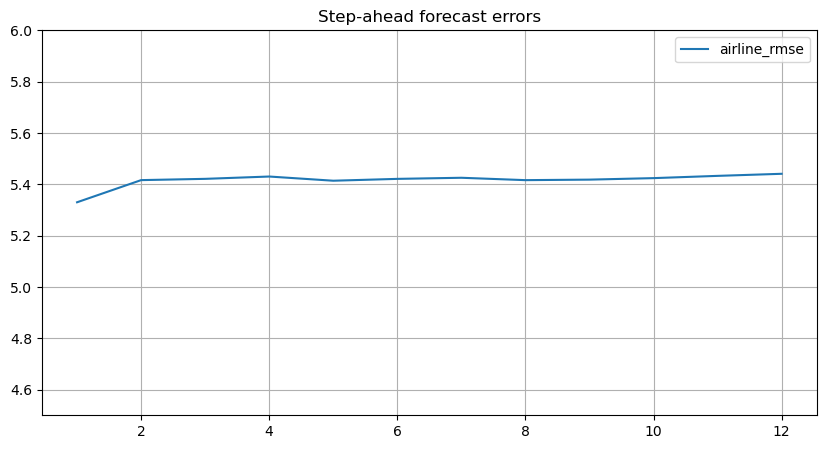

In [15]:
rmse.plot(figsize=(10,5))
plt.title("Step-ahead forecast errors")
plt.grid(True)
plt.ylim(4.5,6)
plt.show()

## 2.2. Fitting some benchmarks: Linear regression

- Recall that in Lecture 5 we discuss how to convert time series data into cross-sectional data, that is, in the form of a feature matrix and target variables.

- In this example, let's use a linear regression model to predict the differences of the original series $\Delta r_{t+1}=r_{t+1}-r_t$ based on $\Delta r_{t},\Delta r_{t-1},...,\Delta r_{t-23}$ (the last two years).

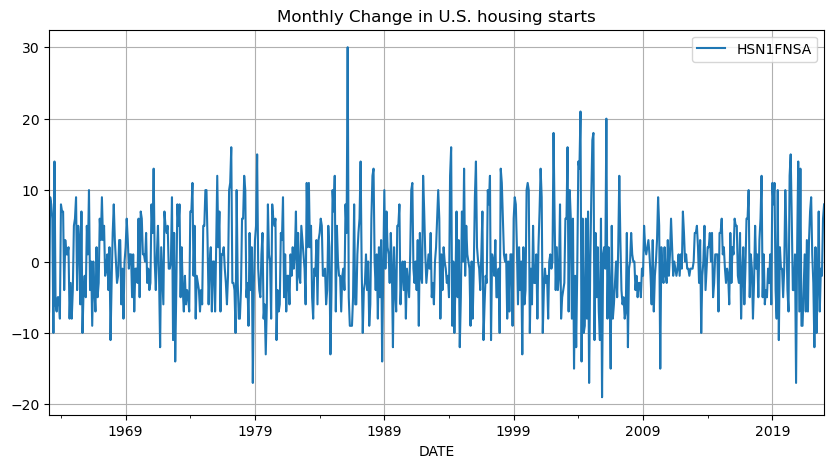

In [16]:
dHS.plot(figsize=(10,5))
plt.title("Monthly Change in U.S. housing starts")
plt.grid(True)
plt.show()

- Then our sample should be put in the form $\{(\mathbf{x}_t,y_t)\}$, where
$$\begin{align*}
    \mathbf{x}_t=(\Delta r_{t-23},\Delta r_{t-22},...,\Delta r_{t}), \quad \quad y_t=\Delta r_{t+1}
\end{align*}$$

In [17]:
def ts_split(ts, feature_steps=24, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)])
    return X, y

In [18]:
ts = dHS.values.flatten()
X, y = ts_split(ts)

- Next, we need to create a training and test set. We are going to take data before the year 2000 as the training set and data after 2000 as the test set.

In [19]:
valid_idx = sum(dHS.index < pd.Timestamp(2000,1,1)) - 24
valid_idx

419

In [20]:
X_train_full, y_train_full = X[:valid_idx], y[:valid_idx]
X_test, y_test = X[valid_idx:], y[valid_idx:]

- We further split the training set into a training and validation set, with the first 75% as training and the last 25% as validation

In [21]:
valid_idx*.75

314.25

In [22]:
train_idx = 314
X_train, y_train = X_train_full[:train_idx], y_train_full[:train_idx]
X_valid, y_valid = X_train_full[train_idx:], y_train_full[train_idx:]

- Next, let us train a linear regression. We can simply train a single neuron without an activation function.

In [23]:
def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

In [24]:
reset_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[24]),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="nadam")

In [25]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.01,
                                                  restore_best_weights=True)
run = model.fit(X_train, y_train, epochs=400,
                validation_data=(X_valid, y_valid),
                callbacks=[early_stopping_cb], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,val_loss
240,19.926111,21.144337
241,19.917847,21.139479
242,19.925404,21.135029
243,19.916302,21.158812
244,19.913530,21.137939
245,19.922270,21.153852
246,19.919134,21.139046
247,19.916142,21.151072
248,19.927149,21.150572
249,19.913845,21.139811


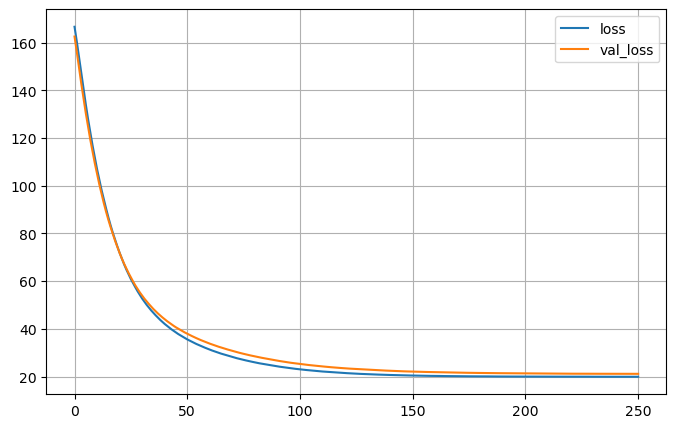

In [26]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

- Let us evaluate the RMSE of the 1-step ahead forecast. We get 5.4, which is better than the performance of the 1-step-ahead forecast of the airline model.

In [27]:
ypred = model.predict(X_test)
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, ypred))

9/9 [==============================] - 0s 652us/step


5.340700616529029

- Suppose we we want to calculate 2-step-ahead, 3-step-ahead, ..., and 12-step-ahead forecasts.

- We do this using the **direct method** mentioned in Lecture 5.

- We need to create the corresponding features and response vector.

In [28]:
X_12ahead, y_12ahead = ts_split(ts, feature_steps=24, target_steps=12)
X_train_12ahead = X_12ahead[:train_idx]
y_train_12ahead = y_12ahead[:train_idx]
X_valid_12ahead = X_12ahead[train_idx:valid_idx]
y_valid_12ahead = y_12ahead[train_idx:valid_idx]
X_test_12ahead = X_12ahead[valid_idx:]
y_test_12ahead = y_12ahead[valid_idx:]

- We can use a 12 neuron layer (without activation) to perform a linear multivariate regression. The loss function is the MSE of all the predictions.

- Using the direct method here is equivalent to using 12 linear regressions. One uses the last 24 time points to predict 1-step-ahead, the next uses the same last 24 time points but to predict 2-steps-ahead, etc.

In [29]:
reset_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[24]),
    tf.keras.layers.Dense(12)
])

model.compile(loss="mse", optimizer="nadam")

In [30]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.01,
                                                  restore_best_weights=True)
run = model.fit(X_train_12ahead, y_train_12ahead, epochs=200,
                validation_data=(X_valid_12ahead, y_valid_12ahead),
                callbacks=[early_stopping_cb], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,val_loss
161,20.028858,24.433399
162,20.024714,24.442030
163,20.022783,24.438702
164,20.016706,24.439421
165,20.015249,24.441681
166,20.013042,24.441622
167,20.009306,24.442341
168,20.009264,24.439125
169,20.005968,24.447479
170,20.004620,24.444605


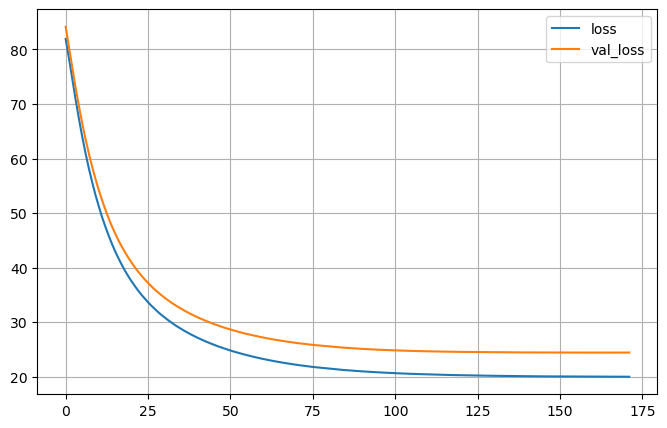

In [31]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

- We can now perform 12-step-ahead forecasting on the test set and compare with the airline model. Linear regression performs better.

In [32]:
ypred = model.predict(X_test_12ahead)
rmse_12ahead = np.sqrt(mean_squared_error(y_test_12ahead, ypred,
                                          multioutput="raw_values"))
rmse_12ahead

9/9 [==============================] - 0s 821us/step


array([5.38793095, 5.37426081, 5.42081055, 5.40906186, 5.46684065,
       5.48411605, 5.44508099, 5.38422084, 5.36932808, 5.2735459 ,
       5.24502725, 5.2900936 ])

In [33]:
rmse["linear"] = rmse_12ahead
rmse

,airline_rmse,linear
1,5.329904,5.387931
2,5.416208,5.374261
3,5.421146,5.420811
4,5.430196,5.409062
5,5.413857,5.466841
6,5.421057,5.484116
7,5.425354,5.445081
8,5.416103,5.384221
9,5.418127,5.369328
10,5.423959,5.273546


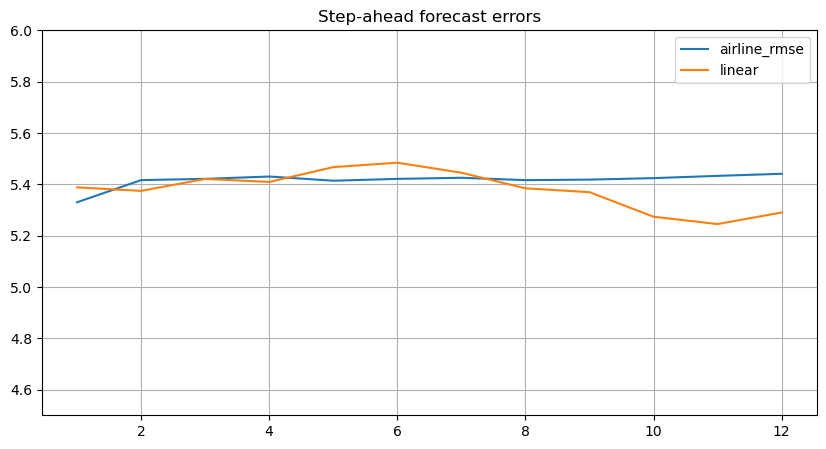

In [34]:
rmse.plot(figsize=(10,5))
plt.title("Step-ahead forecast errors")
plt.grid(True)
plt.ylim(4.5,6)
plt.show()

# 3. Forecasting time series with fully connected RNNs

- Next, let us try to forecast using RNNs. First, we use a single recurrent neuron.


In [59]:
reset_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None,1])
])

model.compile(loss="mse", optimizer="nadam")

- The input of a `tf.keras.layers.SimpleRNN` layer is a three dimensional array of dimensions `(observations, time steps, features)`. As always, we don't need to determine the size of the observations dimension. So, we only need to determine the number of time steps and the number of features (per time step).

- Here, we have a univariate time series, so, `features=1`. We can set `timesteps=None` so that the RNN accepts variable length input sequences.

- The default activation function is `tanh`. You can see the other defaults in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN).

- Let us train the RNN. Note that we have to add a "feature dimension" (by adding `[..., np.newaxis]`) to `X_train`, `X_valid`, and `X_test` before passing to the RNN so they are a 3D array.

In [60]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=200,
                                                  min_delta=0.01,
                                                  restore_best_weights=True)
run = model.fit(X_train[..., np.newaxis], y_train, epochs=200,
                validation_data=(X_valid[..., np.newaxis], y_valid),
                callbacks=[early_stopping_cb])
pd.DataFrame(run.history).iloc[-11:]

Epoch 1/200


10/10 [==============================] - 1s 16ms/step - loss: 37.5104 - val_loss: 40.0926
Epoch 2/200
10/10 [==============================] - 0s 5ms/step - loss: 37.5059 - val_loss: 40.0997
Epoch 3/200
10/10 [==============================] - 0s 5ms/step - loss: 37.5012 - val_loss: 40.1090
Epoch 4/200
10/10 [==============================] - 0s 5ms/step - loss: 37.4954 - val_loss: 40.1175
Epoch 5/200
10/10 [==============================] - 0s 5ms/step - loss: 37.4928 - val_loss: 40.1287
Epoch 6/200
10/10 [==============================] - 0s 5ms/step - loss: 37.4850 - val_loss: 40.1349
Epoch 7/200
10/10 [==============================] - 0s 5ms/step - loss: 37.4811 - val_loss: 40.1433
Epoch 8/200
10/10 [==============================] - 0s 5ms/step - loss: 37.4770 - val_loss: 40.1517
Epoch 9/200
10/10 [==============================] - 0s 5ms/step - loss: 37.4735 - val_loss: 40.1611
Epoch 10/200
10/10 [==============================] - 0s 5ms/step - loss: 37.4685 - val_loss: 40.1678


,loss,val_loss
189,37.095009,39.872055
190,37.091671,39.865322
191,37.089733,39.855965
192,37.085697,39.849312
193,37.083313,39.841431
194,37.080467,39.831326
195,37.077019,39.822239
196,37.073982,39.813824
197,37.070652,39.806583
198,37.068516,39.797089


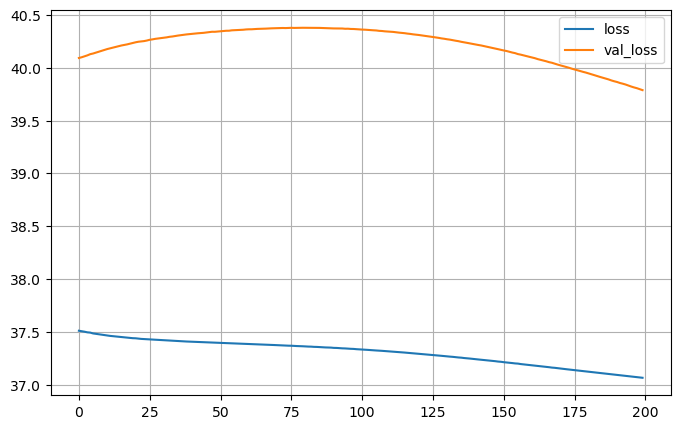

In [61]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()


- The one step ahead performance on the test set is not good at all.

In [62]:
ypred = model.predict(X_test[...,np.newaxis])
np.sqrt(mean_squared_error(y_test, ypred, multioutput="raw_values"))

9/9 [==============================] - 0s 1ms/step


array([6.69296029])

- Since a `SimpleRNN` layer uses the tanh activation function by default, the predicted values must lie within the range -1 to 1. This is not good given that the values we are predicting often lie in the range from -10 to 10.

- Let us try a deep RNN next. Specifically, we stack two layers of RNNs with 20 recurrent neurons each. We then add a single dense neuron to the output of the RNN at the last time step, since the output is a single number. Thus, we need return_sequences=False in the second SimpleRNN layer. Note this uses no activation (the activation function is the identity function).

In [63]:
reset_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(20),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="nadam")

In [64]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.01,
                                                  restore_best_weights=True)
run = model.fit(X_train[..., np.newaxis], y_train, epochs=200,
                validation_data=(X_valid[..., np.newaxis], y_valid),
                callbacks=[early_stopping_cb], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,val_loss
36,15.920609,23.268353
37,15.332130,25.459692
38,15.062219,24.124800
39,14.762373,23.996284
40,14.247367,23.882452
41,14.115506,24.769093
42,13.642630,25.136662
43,13.433135,24.522377
44,12.994604,25.350643
45,12.691219,24.954184


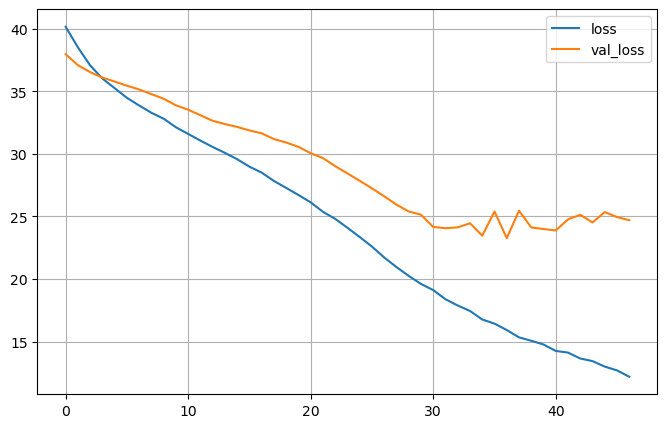

In [65]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

- The performance is slightly better, but still significantly worse than the benchmarks.

In [66]:
ypred = model.predict(X_test[...,np.newaxis])
np.sqrt(mean_squared_error(y_test, ypred, multioutput="raw_values"))

9/9 [==============================] - 0s 2ms/step


array([5.81097106])

- Next, let us try forecasting 12 steps ahead. We would like to use the same sample as the one we used for the linear model (where each observation has 24 features and 12 labels).

- There are many architectures for achieving this. One approach is to add a single fully connected neuron to the output of the RNN at each time step. Note that these fully connected neurons do not share weights. We can then keep the outputs of the last 12 neurons and discard the rest.

- Thus, at time step 13, the RNN predicts time step 25. At time step 14, the RNN predicts time step 26, etc. At time step 24, the RNN predicts time step 36.

- The following code implements this network.

In [67]:
reset_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(20, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)),
    tf.keras.layers.Lambda(lambda Y_pred: Y_pred[:, -12:])
])

model.compile(loss="mse", optimizer="nadam")

- `tf.keras.layers.TimeDistributed` attaches a layer to each time instance of a recurrent network.

- The last `Lambda` layer simply returns the last 12 outputs from the previous layer and discards the rest.

In [68]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.01,
                                                  restore_best_weights=True)
run = model.fit(X_train_12ahead[..., np.newaxis],
                y_train_12ahead[..., np.newaxis],
                epochs=200,
                validation_data=(X_valid_12ahead[..., np.newaxis], 
                                 y_valid_12ahead[..., np.newaxis]),
                callbacks=[early_stopping_cb], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,val_loss
26,16.388079,27.808262
27,15.760515,27.849331
28,15.189604,28.027176
29,14.653313,28.107845
30,14.150487,28.372526
31,13.645959,28.376616
32,13.183305,28.555243
33,12.713892,28.713995
34,12.262505,29.010275
35,11.853812,29.248980


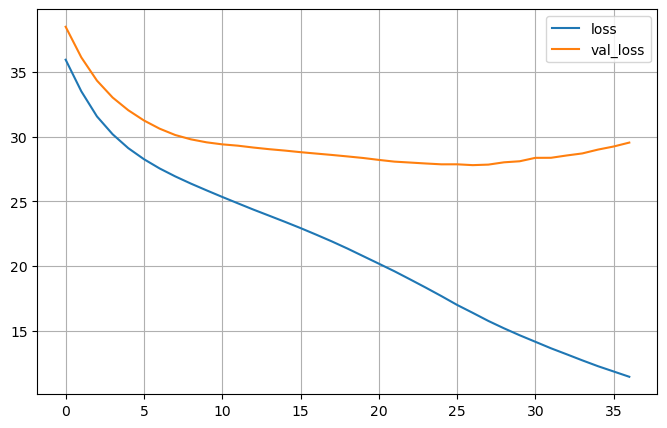

In [69]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

- The model's performance is similar to the airline model, but it is overfitting.

In [70]:
ypred = model.predict(X_test_12ahead[...,np.newaxis])[...,0]
rmse_dRNN = np.sqrt(mean_squared_error(y_test_12ahead, ypred, multioutput="raw_values"))
rmse_dRNN

9/9 [==============================] - 0s 2ms/step


array([5.72885369, 5.74571678, 5.78790325, 5.79768095, 5.72565413,
       5.73070899, 5.75859487, 5.76834796, 5.74173074, 5.73793875,
       5.73853718, 5.73740239])

In [71]:
rmse["deepRNN"] = rmse_dRNN
rmse

,airline_rmse,linear,deepRNN
1,5.329904,5.387931,5.728854
2,5.416208,5.374261,5.745717
3,5.421146,5.420811,5.787903
4,5.430196,5.409062,5.797681
5,5.413857,5.466841,5.725654
6,5.421057,5.484116,5.730709
7,5.425354,5.445081,5.758595
8,5.416103,5.384221,5.768348
9,5.418127,5.369328,5.741731
10,5.423959,5.273546,5.737939


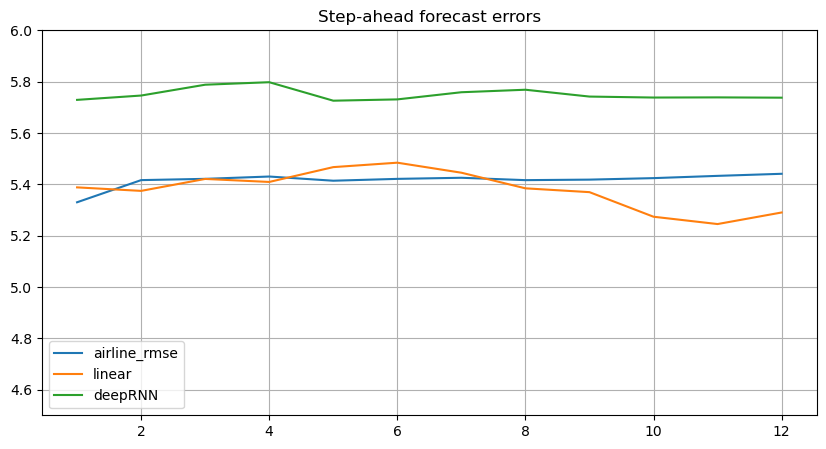

In [72]:
rmse.plot(figsize=(10,5))
plt.title("Step-ahead forecast errors")
plt.grid(True)
plt.ylim(4.5,6)
plt.show()

- We can also apply dropout (both to the weights of the input and the hidden states).

In [100]:
reset_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(20, return_sequences=True,
                           dropout=0.1, recurrent_dropout=0.1,
                           input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(20, return_sequences=True,
                          dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)),
    tf.keras.layers.Lambda(lambda Y_pred: Y_pred[:, -12:])
])

model.compile(loss="mse", optimizer="nadam")

In [101]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=200,
                                                  min_delta=0.01,
                                                  restore_best_weights=True)
run = model.fit(X_train_12ahead[..., np.newaxis], y_train_12ahead[..., np.newaxis], epochs=200,
                validation_data=(X_valid_12ahead[..., np.newaxis], y_valid_12ahead[..., np.newaxis]),
                callbacks=[early_stopping_cb], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,val_loss
189,15.276358,24.209951
190,14.645059,24.082182
191,15.092113,24.369938
192,14.692740,24.754753
193,14.996819,24.685825
194,14.817263,24.390099
195,14.522379,24.435654
196,14.946868,24.687361
197,14.169806,24.596979
198,14.703172,24.079416


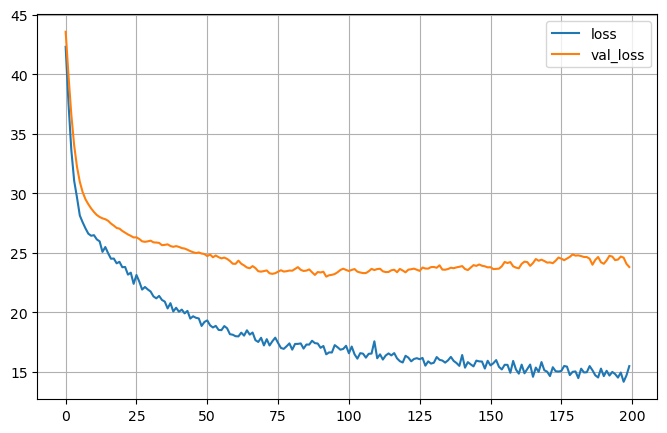

In [102]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

- The performance improves after regularization. It is now on par with the benchmarks.

- We should only consider the validation loss in the learning curve due to the use of drop out. If you want to compare it to the training loss, you will need to predict on the training set.

In [103]:
ypred = model.predict(X_test_12ahead[...,np.newaxis])[...,0]
rmse_dRNN_BN = np.sqrt(mean_squared_error(y_test_12ahead, ypred, multioutput="raw_values"))
rmse_dRNN_BN

9/9 [==============================] - 0s 2ms/step


array([5.5034496 , 5.53718341, 5.5483438 , 5.49928236, 5.4883839 ,
       5.52981354, 5.51275031, 5.51079588, 5.50708251, 5.50934691,
       5.51882695, 5.50928723])

In [116]:
rmse["deepRNN-DO"] = rmse_dRNN_BN
rmse

,airline_rmse,linear,deepRNN,deepRNN-DO
1,5.329904,5.387931,5.728854,5.503450
2,5.416208,5.374261,5.745717,5.537183
3,5.421146,5.420811,5.787903,5.548344
4,5.430196,5.409062,5.797681,5.499282
5,5.413857,5.466841,5.725654,5.488384
6,5.421057,5.484116,5.730709,5.529814
7,5.425354,5.445081,5.758595,5.512750
8,5.416103,5.384221,5.768348,5.510796
9,5.418127,5.369328,5.741731,5.507083
10,5.423959,5.273546,5.737939,5.509347


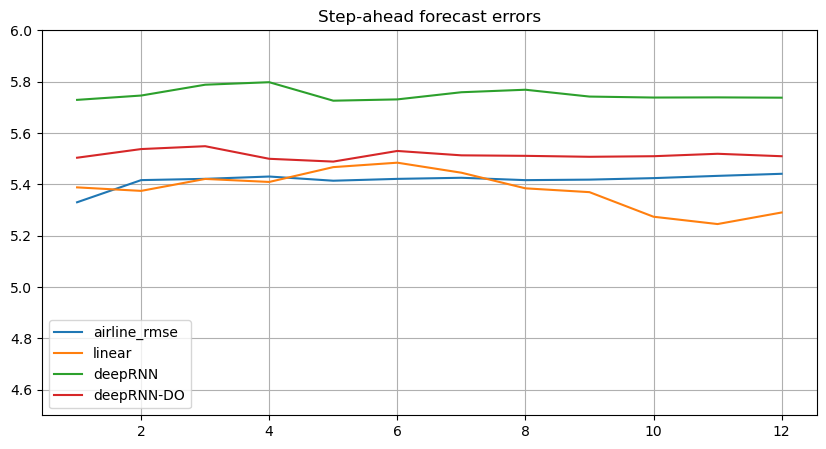

In [115]:
rmse.plot(figsize=(10,5))
plt.title("Step-ahead forecast errors")
plt.grid(True)
plt.ylim(4.5,6)
plt.show()

# 3.1 Additional RNN architectures for prediction several steps ahead

- Here we will consider two additional RNN architectures that can be used for the 12-steps-ahead prediction.

- Consider the following model: add 12 fully connected neurons to the output of the RNN at the last time step. Thus, we need `return_sequences=False` in the second `SimpleRNN` layer.

- So at time step 24, predict time steps 25 to 36.

In [82]:
reset_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(20),
    tf.keras.layers.Dense(12)
])

model.compile(loss="mse", optimizer="nadam")
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.01,
                                                  restore_best_weights=True)
run = model.fit(X_train_12ahead[..., np.newaxis],
                y_train_12ahead[..., np.newaxis],
                epochs=200,
                validation_data=(X_valid_12ahead[..., np.newaxis], 
                                 y_valid_12ahead[..., np.newaxis]),
                callbacks=[early_stopping_cb], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,val_loss
147,13.484599,20.554930
148,13.423687,20.618950
149,13.373846,20.558746
150,13.330033,20.617752
151,13.288737,20.559748
152,13.331980,20.694424
153,13.419458,21.367088
154,13.605680,20.624371
155,13.332631,20.796692
156,13.265255,20.738497


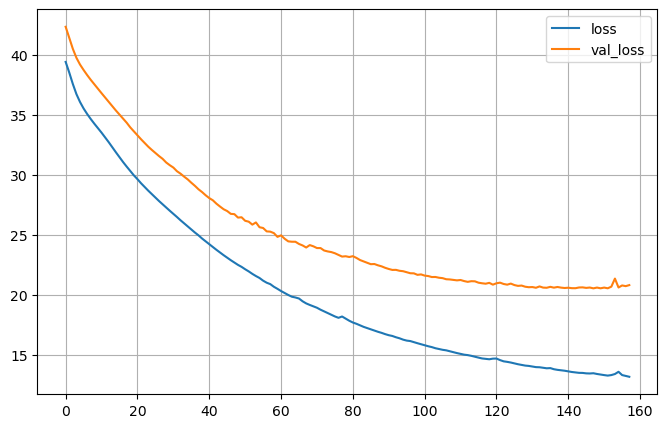

In [83]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [84]:
ypred = model.predict(X_test_12ahead[..., np.newaxis])
rmse_dRNN_dense_end = np.sqrt(mean_squared_error(y_test_12ahead, ypred, multioutput="raw_values"))
rmse_dRNN_dense_end

9/9 [==============================] - 0s 2ms/step


array([5.93994372, 5.98296541, 5.85425116, 6.04496194, 6.04177829,
       5.8400648 , 5.87078421, 5.99382375, 5.62276834, 6.07275554,
       6.03585006, 5.87692561])

In [85]:
rmse["dRNN_dense_end"] = rmse_dRNN_dense_end
rmse

,airline_rmse,linear,deepRNN,deepRNN-DO,dRNN_dense_end
1,5.329904,5.387931,5.728854,5.597288,5.939944
2,5.416208,5.374261,5.745717,5.499405,5.982965
3,5.421146,5.420811,5.787903,5.573832,5.854251
4,5.430196,5.409062,5.797681,5.581286,6.044962
5,5.413857,5.466841,5.725654,5.572769,6.041778
6,5.421057,5.484116,5.730709,5.544363,5.840065
7,5.425354,5.445081,5.758595,5.593588,5.870784
8,5.416103,5.384221,5.768348,5.647497,5.993824
9,5.418127,5.369328,5.741731,5.569955,5.622768
10,5.423959,5.273546,5.737939,5.590425,6.072756


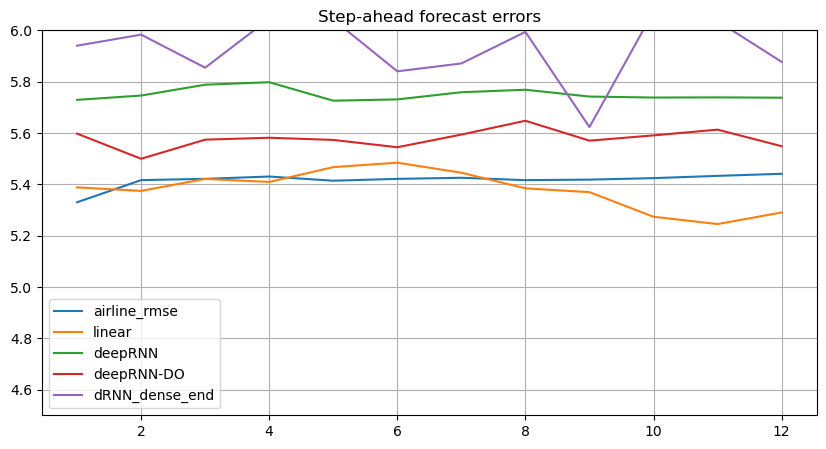

In [86]:
rmse.plot(figsize=(10,5))
plt.title("Step-ahead forecast errors")
plt.grid(True)
plt.ylim(4.5,6)
plt.show()

- For a fair comparison, the RMSE on the test set here is close to but slightly higher than the deep RNN without regularization (though if you compared the RMSE on the validation set, it would be better than the previous model).

- Finally, consider the following model: add 12 fully connected neurons to the output of the RNN at each time step. Thus, we need return_sequences=True in the second SimpleRNN layer. Then train this on each of the corresponding 12-steps-ahead values.

- So at time step 1, predict time steps 2 to 13. At time step 2, predict time steps 3 to 14, etc. At time step 24, predict time steps 25 to 36.

- We need to recreate the X and y variables to correspond to this.

In [87]:
n_steps = 24
n_ahead = 12
n_sample = X_12ahead.shape[0]
series = np.concatenate((X_12ahead, y_12ahead), axis=1)[...,np.newaxis]
X_train = series[:train_idx, :n_steps]
X_valid = series[train_idx:valid_idx, :n_steps]
X_test = series[valid_idx:, :n_steps]
Y = np.empty((n_sample, n_steps, n_ahead))
for step_ahead in range(1, n_ahead + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
y_train = Y[:train_idx]
y_valid = Y[train_idx:valid_idx]
y_test = Y[valid_idx:]

In [88]:
print(X_train.shape)
print(y_train.shape)

(314, 24, 1)
(314, 24, 12)


- All outputs are needed during training, but only the output at the last time step is useful for predictions and for evaluation. This is because we are only concerned with the 12-steps-ahead predictions, that is, at time step 24, the predictions for time steps 25 to 36.

- So we create a custom metric for evaluation, last_time_step_mse, which only computes the MSE over the output at the last time step.

In [89]:
reset_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(20, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(12))
])
def last_time_step_mse(Y_true, Y_pred):
    return tf.keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer="nadam",metrics=[last_time_step_mse])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.01,
                                                  restore_best_weights=True, monitor="val_last_time_step_mse", mode="min")
run = model.fit(X_train, y_train, epochs=200,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,last_time_step_mse,val_loss,val_last_time_step_mse
96,19.503294,15.337969,26.339314,23.897221
97,19.462309,15.296000,26.438002,24.073765
98,19.407213,15.221258,26.437895,23.989552
99,19.371107,15.176995,26.313128,23.942278
100,19.311834,15.120502,26.434244,24.019190
101,19.279333,15.068614,26.409904,23.991533
102,19.237131,15.013556,26.453720,24.076460
103,19.191050,14.975857,26.551941,24.014784
104,19.150345,14.917029,26.473259,24.012827
105,19.107779,14.857533,26.503273,23.996601


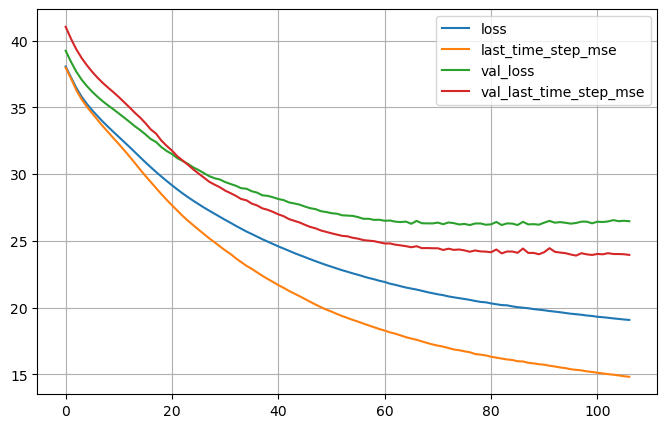

In [90]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [91]:
ypred = model.predict(X_test)
rmse_dRNN_dense_each = np.sqrt(mean_squared_error(y_test[:, -1], ypred[:, -1], multioutput="raw_values"))
rmse_dRNN_dense_each

9/9 [==============================] - 0s 3ms/step


array([6.22151219, 6.28390583, 6.11259282, 6.1025024 , 6.17107424,
       6.0678099 , 6.08656594, 6.05457946, 5.84949806, 5.76351968,
       5.74052611, 5.62392333])

In [92]:
rmse["deepRNN_dense_each"] = rmse_dRNN_dense_each
rmse

,airline_rmse,linear,deepRNN,deepRNN-DO,dRNN_dense_end,deepRNN_dense_each
1,5.329904,5.387931,5.728854,5.597288,5.939944,6.221512
2,5.416208,5.374261,5.745717,5.499405,5.982965,6.283906
3,5.421146,5.420811,5.787903,5.573832,5.854251,6.112593
4,5.430196,5.409062,5.797681,5.581286,6.044962,6.102502
5,5.413857,5.466841,5.725654,5.572769,6.041778,6.171074
6,5.421057,5.484116,5.730709,5.544363,5.840065,6.067810
7,5.425354,5.445081,5.758595,5.593588,5.870784,6.086566
8,5.416103,5.384221,5.768348,5.647497,5.993824,6.054579
9,5.418127,5.369328,5.741731,5.569955,5.622768,5.849498
10,5.423959,5.273546,5.737939,5.590425,6.072756,5.763520


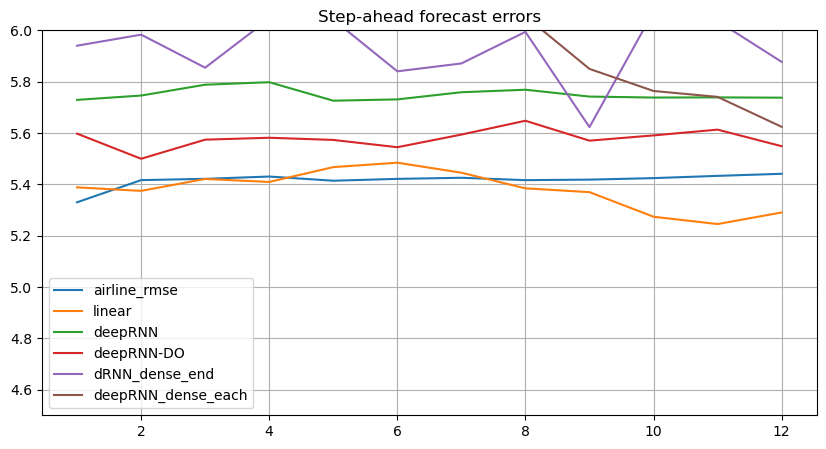

In [93]:
rmse.plot(figsize=(10,5))
plt.title("Step-ahead forecast errors")
plt.grid(True)
plt.ylim(4.5,6)
plt.show()

- In this example, this model does worse than the previous models. Although you may get different results for different datasets. The model may also be improved by regularization. For the simulated example in Chapter 15 of the textbook (2nd edition), this method is better than the previous models.

# 4. Long Short Term Memory (LSTM)

- When an RNN processes a long sequence, it will gradually forget the older inputs in the sequence.

- To address this, **Long Term Short Term Memory (LSTM)** cells were designed to model long-term dependencies in the data. To use a LSTM, just swap out the simple RNN cells for LSTM cells.

- The inputs of a LSTM cell are the cell state $\mathbf{c}_{t-1}$ which represents long-term memory, and the hidden state $\mathbf{h}_{t-1}$, which represents short-term memory, and the time series observation $\mathbf{x}_{t}$

- The outputs of a LSTM cell are the updated cell and hidden states $\mathbf{c}_t$, $\mathbf{h}_t$, and the output $\mathbf{y}_t$. So we can think of $(\mathbf{c}_t,\mathbf{h}_t)$ as the joint hidden state in the original definition of a RNN.

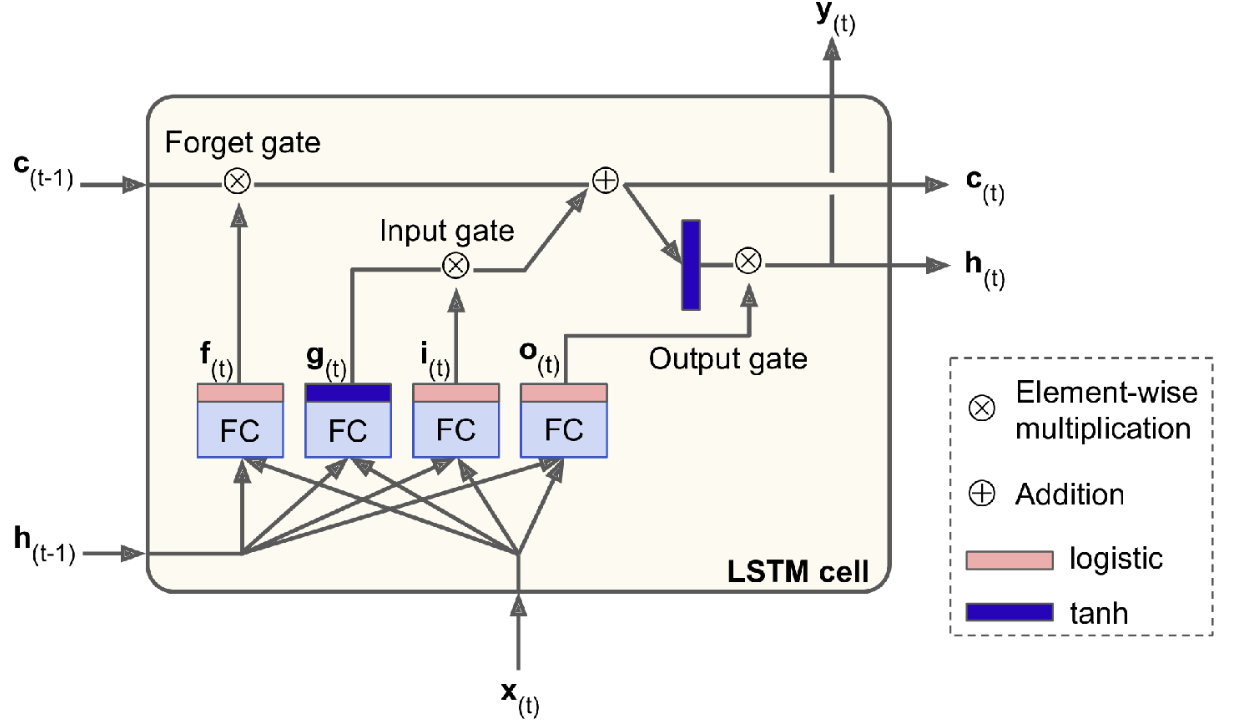

In [94]:
from IPython.display import Image
Image("Figs/LSTM.png",width=600)

- Let $\sigma$ be the logistic sigmoid function. The formulas for a LSTM are given by
$$\begin{align*}
\mathbf{i}_t&=\sigma(\mathbf{W}^T_{x,i}\mathbf{x}_t+\mathbf{W}^T_{h,i}\mathbf{h}_{t-1}+\mathbf{b}_i)\\
\mathbf{f}_t&=\sigma(\mathbf{W}^T_{x,f}\mathbf{x}_t+\mathbf{W}^T_{h,f}\mathbf{h}_{t-1}+\mathbf{b}_f)\\
\mathbf{o}_t&=\sigma(\mathbf{W}^T_{x,o}\mathbf{x}_t+\mathbf{W}^T_{h,o}\mathbf{h}_{t-1}+\mathbf{b}_o)\\
\mathbf{g}_t&=\tanh(\mathbf{W}^T_{x,g}\mathbf{x}_t+\mathbf{W}^T_{h,g}\mathbf{h}_{t-1}+\mathbf{b}_g)\\
\mathbf{c}_t&=\mathbf{f}_t\otimes \mathbf{c}_{t-1}+\mathbf{i}_t\otimes \mathbf{g}_t\\
\mathbf{y}_t&=\mathbf{h}_t = \mathbf{o}_t\otimes \tanh\mathbf{c}_t\\
\end{align*}$$

- $\mathbf{g}_t$ plays the usual role of analyzing the current input $\mathbf{x}_t$ and the previous short-term memory state $\mathbf{h}_t$.

- $\mathbf{f}_t$, $\mathbf{i}_t$, $\mathbf{o}_t$ are numbers between 0 and 1.

- $\mathbf{f}_t$ is the **forget gate** since it acts as a multiplier for the amount of past memory $\mathbf{c}_{t=1}$ to forget from $\mathbf{c}_t$.

- $\mathbf{i}_t$ is the input gate since it acts as a multiplier for the amount of new memory $\mathbf{g}_t$ to write into $\mathbf{c}_{t-1}$.

- $\mathbf{o}_t$ is the output gate since it acts as a multiplier for the output $\tanh(\mathbf{c}_t)$ to send out to $\mathbf{y}_t$ and $\mathbf{h}_t$. 

- $\mathbf{W}_{x,i}$, $\mathbf{W}_{x,f}$, $\mathbf{W}_{x,o}$, $\mathbf{W}_{x,g}$ are weight matricies for $\mathbf{x}_{t}$.

- $\mathbf{W}_{h,i}$, $\mathbf{W}_{h,f}$, $\mathbf{W}_{h,o}$, $\mathbf{W}_{h,g}$ are weight matricies for $\mathbf{h}_{t-1}$

- $\mathbf{b}_{i}$, $\mathbf{b}_{f}$, $\mathbf{b}_{o}$, $\mathbf{b}_{g}$  are bias terms.

- The $\tanh$ function allows $\mathbf{g}_{t}$, the memory states $\mathbf{c}_{t}$, $\mathbf{h}_{t}$ and the output $\mathbf{y}_{t}$ to take positive or negative values.

- RNNs typically suffer from the vanishing or exploding gradient problem. While the ReLU activation function helps with vanishing gradient it doesn't help with exploding gradients, which is why a saturating activation function like tanh and weight initialization is used.

- To sum up, an LSTM cell can learn to recognize an important input (that’s the role of the input gate), store it in the long-term state, preserve it for as long as it is needed (that’s the role of the forget gate), and extract it whenever it is needed.



- LSTM layers can be used in Keras with `tf.keras.layers.LSTM`. You can simply replace `tf.keras.layers.SimpleRNN` with `tf.keras.layers.LSTM`.

- Here, we apply LSTM instead of simple RNNs in the last model that we used for 12-steps-ahead prediction.

In [95]:
reset_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(12))
])
def last_time_step_mse(Y_true, Y_pred):
    return tf.keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer="nadam",metrics=[last_time_step_mse])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.01,
                                                  restore_best_weights=True, monitor="val_last_time_step_mse", mode="min")
run = model.fit(X_train, y_train, epochs=200,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,last_time_step_mse,val_loss,val_last_time_step_mse
125,21.844883,18.236088,25.942896,24.051617
126,21.796698,18.193317,26.058670,24.203636
127,21.749414,18.113792,26.033121,24.199673
128,21.690273,18.056988,26.029915,24.210361
129,21.640032,18.027069,26.040648,24.171236
130,21.597395,17.950283,25.981424,24.173130
131,21.547350,17.902092,25.991219,24.156689
132,21.492992,17.839439,26.056557,24.231987
133,21.436298,17.777060,26.002583,24.165842
134,21.382816,17.711258,26.009478,24.169016


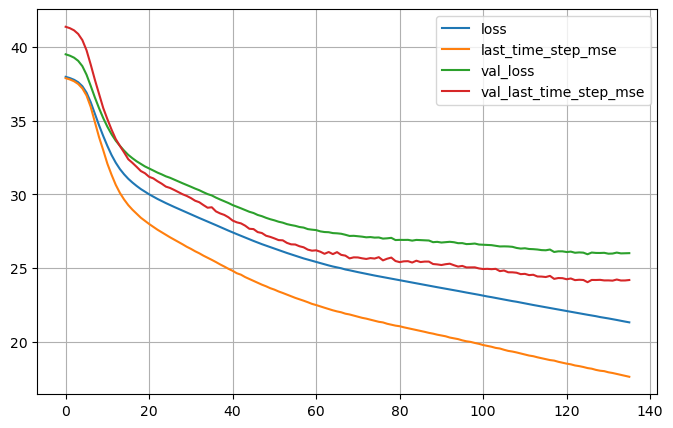

In [96]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [97]:
ypred = model.predict(X_test)
rmse_dLSTM_dense_each = np.sqrt(mean_squared_error(y_test[:, -1], ypred[:, -1], multioutput="raw_values"))
rmse_dLSTM_dense_each

9/9 [==============================] - 0s 3ms/step


array([5.81829794, 5.86150153, 5.78991397, 6.03437744, 6.13839395,
       6.1070149 , 6.06542565, 6.03853499, 5.97279182, 6.04051551,
       6.0235033 , 5.89988483])

In [98]:
rmse["deepLSTM_dense_each"] = rmse_dLSTM_dense_each
rmse

,airline_rmse,linear,deepRNN,deepRNN-DO,dRNN_dense_end,deepRNN_dense_each,deepLSTM_dense_each
1,5.329904,5.387931,5.728854,5.597288,5.939944,6.221512,5.818298
2,5.416208,5.374261,5.745717,5.499405,5.982965,6.283906,5.861502
3,5.421146,5.420811,5.787903,5.573832,5.854251,6.112593,5.789914
4,5.430196,5.409062,5.797681,5.581286,6.044962,6.102502,6.034377
5,5.413857,5.466841,5.725654,5.572769,6.041778,6.171074,6.138394
6,5.421057,5.484116,5.730709,5.544363,5.840065,6.067810,6.107015
7,5.425354,5.445081,5.758595,5.593588,5.870784,6.086566,6.065426
8,5.416103,5.384221,5.768348,5.647497,5.993824,6.054579,6.038535
9,5.418127,5.369328,5.741731,5.569955,5.622768,5.849498,5.972792
10,5.423959,5.273546,5.737939,5.590425,6.072756,5.763520,6.040516


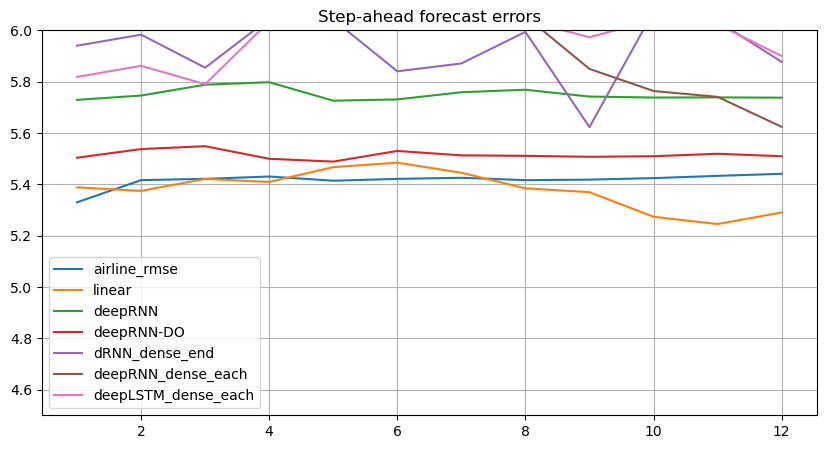

In [117]:
rmse.plot(figsize=(10,5))
plt.title("Step-ahead forecast errors")
plt.grid(True)
plt.ylim(4.5,6)
plt.show()